In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
import sklearn.ensemble as ensem
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import sklearn.metrics as metric
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import catboost as cb
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

### Parámetros

In [76]:
P_columnasEliminar = 15
P_eliminarOutliers = False
P_thresholdVariance = 0.8 
P_estrategiaSustitucionAtributos = 'mean' #'median'
P_numatributosImportantes=70
P_eliminarUmbralCorrelacion=1.0
P_pintarDistribucionYoutliers=False

### Lectura ficheros

In [77]:
transactions = pd.read_csv("ieee-fraud-detection/train_transaction.csv",header=0)

In [78]:
identities = pd.read_csv("ieee-fraud-detection/train_identity.csv",header=0)

In [79]:
print(len(transactions))

590540


In [80]:
print(len(identities))

144233


In [81]:
#Visualizar todas las columnas
pd.options.display.max_columns=1000
transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [82]:
identities.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### Proporción de transacciones fraudulentas y no fraudulentas

In [83]:
print('Número de transacciones no fraudulentas '+str(len(transactions[transactions['isFraud']==0])))
print('Número de transacciones fraudulentas '+str(len(transactions[transactions['isFraud']==1])))                                                            

Número de transacciones no fraudulentas 569877
Número de transacciones fraudulentas 20663


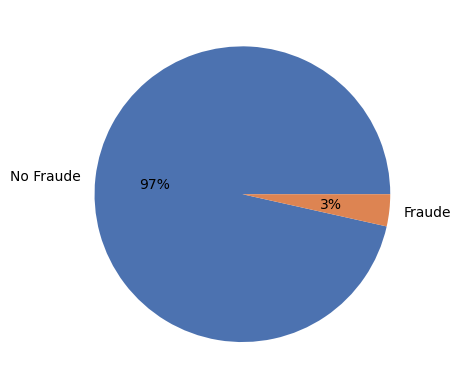

In [84]:
#https://seaborn.pydata.org/tutorial/color_palettes.html
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = [len(transactions[transactions['isFraud']==0]),len(transactions[transactions['isFraud']==1])]
labels = ['No Fraude','Fraude']
#define Seaborn color palette to use
colors = sns.color_palette('deep')
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

### Descripción de las variables categóricas

In [85]:
t=transactions.head(10).copy()
t

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [86]:
def pintarDistribucionCategorica(df,columna, width=5, height=5, horizontal=False, limite=False):  
    dfPD=df[columna].drop_duplicates(keep='first')
    keys=[]
    valores=[]
    i=0
    print(columna)
    for i in range(len(dfPD)):
        valor=str(dfPD.iloc[i])       
        numelementos=len(df[df[columna]==valor])
        keys.insert(i,valor)
        valores.insert(i,numelementos)                                  
        i=i+1        
    
    if limite == True:
        print("Registros totales "+str(i))
        keyValues=pd.DataFrame()
        keyValues['keys']=keys
        keyValues['values']=valores
        keyValuesSorted=keyValues.sort_values('values',ascending=True)
        keyValuesTop=keyValuesSorted.tail(10).copy()       
        keys = (keyValuesTop['keys'].values).tolist()        
        valores= (keyValuesTop['values'].values).tolist()
    
   
    plt.figure(figsize=(width,height))
    if horizontal==True:
        plt.barh(keys, valores, color=(0.2, 0.4, 0.6, 0.6), align='center')  
    else:
        plt.bar(keys, valores, color=(0.2, 0.4, 0.6, 0.6), align='center')  
    plt.show()

ProductCD


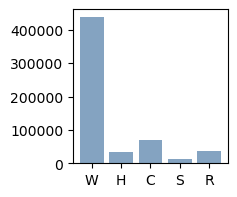

card4


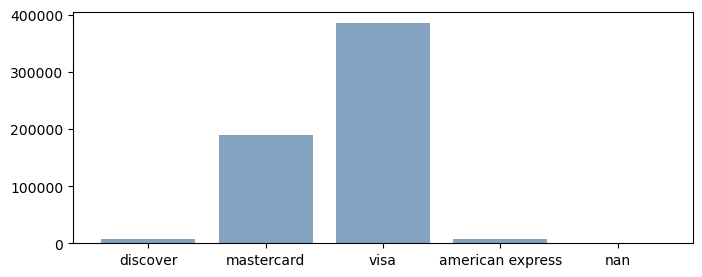

card6


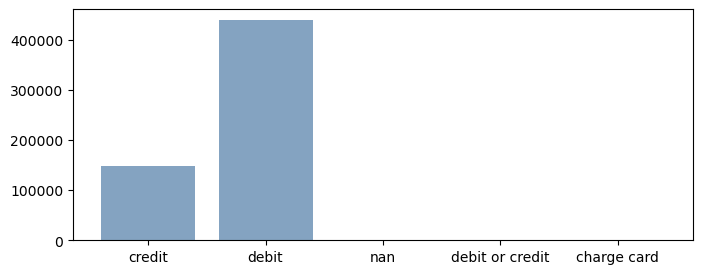

id_34


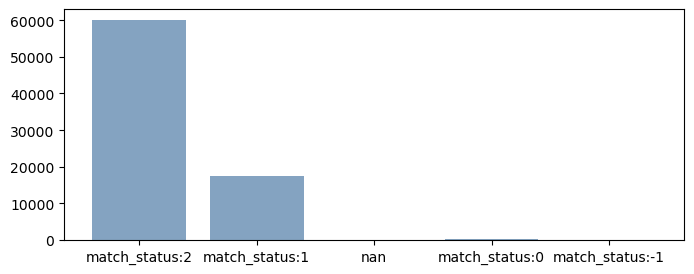

DeviceType


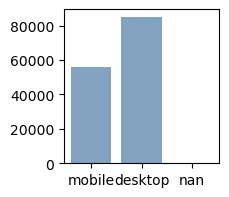

id_31
Registros totales 131


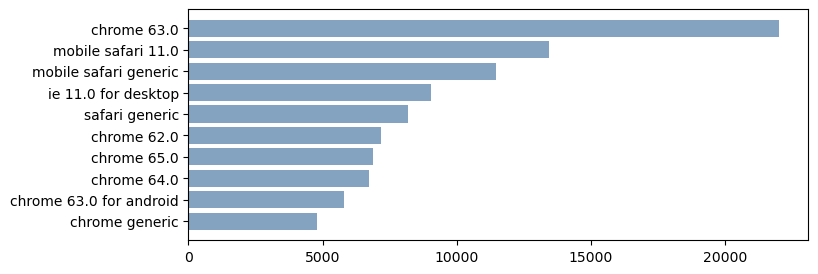

id_35


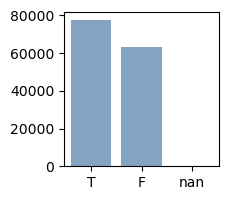

id_36


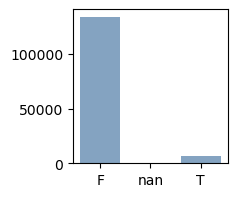

id_37


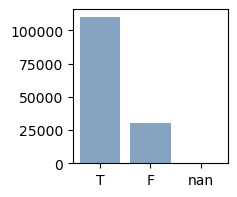

id_38


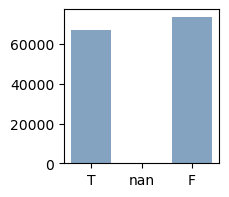

DeviceInfo
Registros totales 1787


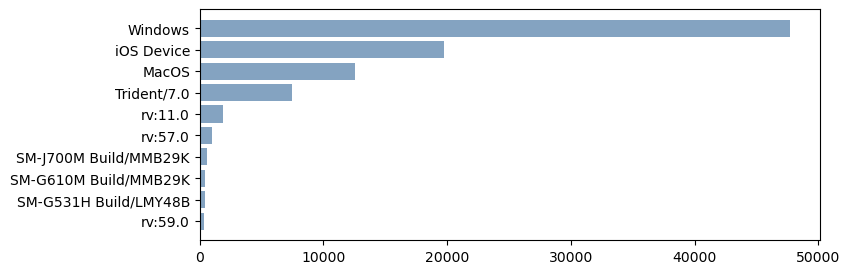

In [87]:
##Las que están comentadas es porque a posteriori se vio que no eran relevantes para el análisis

pintarDistribucionCategorica(transactions,'ProductCD',2,2)
pintarDistribucionCategorica(transactions,'card4',8,3)
pintarDistribucionCategorica(transactions,'card6',8,3)
pintarDistribucionCategorica(identities,'id_34',8,3)
pintarDistribucionCategorica(identities,'DeviceType',2,2)
pintarDistribucionCategorica(identities,'id_31',8,3,True,True)
pintarDistribucionCategorica(identities,'id_35',2,2)
pintarDistribucionCategorica(identities,'id_36',2,2)
pintarDistribucionCategorica(identities,'id_37',2,2)
pintarDistribucionCategorica(identities,'id_38',2,2)

pintarDistribucionCategorica(identities,'DeviceInfo',8,3,True,True) # se ve mal

#Al final desaparecen

#pintarDistribucionCategorica(transactions,'P_emaildomain',10,10) 
#pintarDistribucionCategorica(transactions,'R_emaildomain',10,10)
#pintarDistribucionCategorica(identities,'id_30',10,10)
#pintarDistribucionCategorica(identities,'id_32')
#pintarDistribucionCategorica(identities,'id_33',10,10)
#pintarDistribucionCategorica(identities,'id_34',10,10)


### Análisis estadístico general

In [88]:
transactions.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.00

In [89]:
identities.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,0.000000,100.000000,49.000000,-360.000000,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,0.000000,100.000000,64.000000,720.000000,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


### Columnas con un alto porcentaje de nulos

In [90]:
def porcentajeNulos(df):
    columns_names = df.columns.values
    tablaPorcentajeNulos = pd.DataFrame(columns=columns_names)
    total = len(df)
    for i in range(0,len(columns_names)):        
        nombreColumna=columns_names[i]
        nulos=df[nombreColumna].isnull().sum()
        nonulos=df[nombreColumna].notnull().sum()        
        porcentajeNulos=(nulos*100)/total        
        tablaPorcentajeNulos[nombreColumna]=[porcentajeNulos]
    return tablaPorcentajeNulos

def eliminarColumnas(df,porcentaje):    
    dfNueva = df.copy()
    if porcentaje==0:
        return dfNueva
    columns_names = df.columns.values    
    total = len(df)
    totalEliminar=0
    totalColumnas=0
    for i in range(0,len(columns_names)):        
        nombreColumna=columns_names[i]
        nulos=df[nombreColumna].isnull().sum()
        nonulos=df[nombreColumna].notnull().sum()        
        porcentajeNulos=(nulos*100)/total     
        if porcentajeNulos>porcentaje:
            dfNueva=dfNueva.drop(nombreColumna, axis=1)
            totalEliminar+=1
        totalColumnas+=1
    print("Número total de columnas "+str(totalColumnas))
    print("Número de columnas eliminadas "+str(totalEliminar))
    return dfNueva

def valoresUnicos(df):
    columns_names = df.columns.values
    tablaUnicos = pd.DataFrame(columns=columns_names)
    for i in range(0,len(columns_names)):        
        nombreColumna=columns_names[i]
        unicos=df[nombreColumna].unique().tolist()         
        tablaUnicos[nombreColumna]=[unicos]
    return tablaUnicos



def graficoValoresNulosPorcentajes(df):   
    
    ejey=[]
    ejex=['0-15% nulos','16-35% nulos','36-55% nulos','56-75% nulos','>75% nulos']
    menorIgual15=0
    menorIgual35=0
    menorIgual55=0
    menorIgual75=0
    mayor75=0
    columnas15=''
    columnas35=''
    columnas55=''
    columnas75=''
    columnasmas75=''
    for indice, fila in df.iterrows():
        for columna, valor in fila.items():
            if valor<=15:               
                menorIgual15+=1
                columnas15+=' '+columna
            if valor>15 and valor<=35:
                menorIgual35+=1
                columnas35+=' '+columna
            if valor>35 and valor<=55:
                menorIgual55+=1
                columnas55+=' '+columna
            if valor>55 and valor<=75:
                menorIgual75+=1
                columnas75+=' '+columna
            elif valor>75:                
                mayor75+=1
                columnasmas75+=' '+columna
            
    ejey=[menorIgual15,menorIgual35,menorIgual55,menorIgual75,mayor75]
    
    plt.figure(figsize=(5,5))   
    #plt.bar(ejex, ejey, color=(0.2, 0.4, 0.6, 0.6), align='center')
    colors = sns.color_palette('deep')
    plt.pie(ejey, labels = ejex, colors = colors, autopct='%.0f%%')
    
    plt.show()
    
    resultados = pd.DataFrame()   
    columnas=[columnas15,columnas35,columnas55,columnas75,columnasmas75]
    print(ejex)
    print(columnas)
    
    return resultados



#### Transactions

In [91]:
transaccionesYPorcentajeNulos=porcentajeNulos(transactions)
transaccionesYPorcentajeNulos

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0.0,0.0,0.0,0.0,0.0,0.0,1.512683,0.265012,0.267044,0.721204,0.266028,11.126427,11.126427,59.652352,93.628374,15.994852,76.751617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214888,47.549192,44.514851,28.604667,52.467403,87.606767,93.40993,87.31229,87.31229,12.873302,47.293494,89.041047,89.509263,89.469469,15.090087,45.907136,45.907136,45.907136,47.658753,59.349409,28.678836,58.635317,58.633115,58.633115,47.293494,47.293494,47.293494,47.293494,47.293494,47.293494,47.293494,47.293494,47.293494,47.293494,47.293494,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,12.881939,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,28.612626,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,13.05517,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,15.098723,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,0.053172,86.123717,86.123717,86.123717,86.123717,86.123717,86.122701,86.122701,86.122701,86.123717,86.123717,86.123717,86.123717,86.122701,86.122701,86.122701,86.123717,86.123717,86.123717,86.123717,86.123717,86.123717,86.122701,86.122701,86.123717,86.123717,86.123717,86.122701,86.122701,86.122701,76.35537,76.35537,76.323534,76.323534,76.323534,76.35537,76.35537,76.323534,76.323534,76.35537,76.35537,76.35537,76.3553

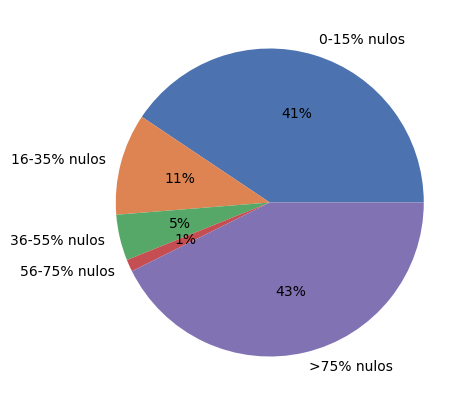

['0-15% nulos', '16-35% nulos', '36-55% nulos', '56-75% nulos', '>75% nulos']
[' TransactionID isFraud TransactionDT TransactionAmt ProductCD card1 card2 card3 card4 card5 card6 addr1 addr2 C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12 C13 C14 D1 D10 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 V29 V30 V31 V32 V33 V34 V53 V54 V55 V56 V57 V58 V59 V60 V61 V62 V63 V64 V65 V66 V67 V68 V69 V70 V71 V72 V73 V74 V95 V96 V97 V98 V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126 V127 V128 V129 V130 V131 V132 V133 V134 V135 V136 V137 V279 V280 V281 V282 V283 V284 V285 V286 V287 V288 V289 V290 V291 V292 V293 V294 V295 V296 V297 V298 V299 V300 V301 V302 V303 V304 V305 V306 V307 V308 V309 V310 V311 V312 V313 V314 V315 V316 V317 V318 V319 V320 V321', ' P_emaildomain D4 D15 M6 V35 V36 V37 V38 V39 V40 V41 V42 V43 V44 V45 V46 V47 V48 V49 V50 V51 V52 V75 V76 V77 V78 V79 V80 V81 V82 V83 V84 V85 V86 V87

""


In [92]:
resultados=graficoValoresNulosPorcentajes(transaccionesYPorcentajeNulos)
resultados

In [93]:
transaccionesNulosEliminados=eliminarColumnas(transactions,P_columnasEliminar)#Eliminar columnas en las cuales un 15% de los valores sea nulo
transaccionesNulosEliminados.head()

Número total de columnas 394
Número de columnas eliminadas 234


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0

#### Identities

In [94]:
identitiesYPorcentajeNulos=porcentajeNulos(identities)
identitiesYPorcentajeNulos.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0.0,0.0,2.330257,54.016071,54.016071,5.108401,5.108401,96.425922,96.425922,48.05211,48.05211,2.256765,0.0,11.726165,44.503685,2.251912,10.325654,3.372321,68.722137,3.407681,3.4472,96.423149,96.416215,96.416215,96.708798,96.441868,96.420375,96.416215,2.256765,2.256765,46.222432,2.739318,46.207872,49.187079,46.056034,2.251912,2.251912,2.251912,2.251912,2.373243,17.726179


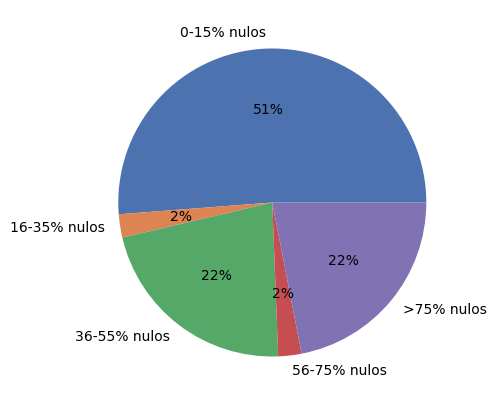

['0-15% nulos', '16-35% nulos', '36-55% nulos', '56-75% nulos', '>75% nulos']
[' TransactionID id_01 id_02 id_05 id_06 id_11 id_12 id_13 id_15 id_16 id_17 id_19 id_20 id_28 id_29 id_31 id_35 id_36 id_37 id_38 DeviceType', ' DeviceInfo', ' id_03 id_04 id_09 id_10 id_14 id_30 id_32 id_33 id_34', ' id_18', ' id_07 id_08 id_21 id_22 id_23 id_24 id_25 id_26 id_27']


""


In [95]:
resultadosI=graficoValoresNulosPorcentajes(identitiesYPorcentajeNulos)
resultadosI

In [96]:
identitiesNulosEliminados=eliminarColumnas(identities,P_columnasEliminar)#Eliminar columnas en las cuales un 15% de los valores sea nulo
identitiesNulosEliminados.head()

Número total de columnas 41
Número de columnas eliminadas 20


,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,NaN,New,NotFound,166.0,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,49.0,New,NotFound,166.0,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,52.0,Found,Found,121.0,410.0,142.0,Found,Found,chrome 62.0,F,F,T,T,desktop
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,52.0,New,NotFound,225.0,176.0,507.0,New,NotFound,chrome 62.0,F,F,T,T,desktop
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,NaN,Found,Found,166.0,529.0,575.0,Found,Found,chrome 62.0,T,F,T,T,desktop


### Valores posibles para cada columna

In [97]:
valoresUnicos(transaccionesNulosEliminados)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,"[2987000, 2987001, 2987002, 2987003, 2987004, ...","[0, 1]","[86400, 86401, 86469, 86499, 86506, 86510, 865...","[68.5, 29.0, 59.0, 50.0, 49.0, 159.0, 422.5, 1...","[W, H, C, S, R]","[13926, 2755, 4663, 18132, 4497, 5937, 12308, ...","[nan, 404.0, 490.0, 567.0, 514.0, 555.0, 360.0...","[150.0, 117.0, 185.0, 143.0, 144.0, 163.0, 146...","[discover, mastercard, visa, american express,...","[142.0, 102.0, 166.0, 117.0, 226.0, 224.0, 134...","[credit, debit, nan, debit or credit, charge c...","[315.0, 325.0, 330.0, 476.0, 420.0, 272.0, 126...","[87.0, nan, 96.0, 35.0, 60.0, 98.0, 43.0, 65.0...","[1.0, 2.0, 4.0, 6.0, 127.0, 3.0, 8.0, 92.0, 19...","[1.0, 5.0, 2.0, 4.0, 120.0, 86.0, 145.0, 6.0, ...","[0.0, 1.0, 8.0, 3.0, 2.0, 16.0, 4.0, 9.0, 10.0...","[0.0, 1.0, 2.0, 3.0, 4.0, 46.0, 47.0, 48.0, 21...","[0.0, 2.0, 1.0, 168.0, 3.0, 121.0, 142.0, 5.0,...","[1.0, 4.0, 3.0, 5.0, 7.0, 99.0, 2.0, 0.0, 6.0,...","[0.0, 1.0, 2.0, 4.0, 46.0, 3.0, 47.0, 48.0, 10...","[0.0, 1.0, 6.0, 2.0, 5.0, 13.0, 4.0, 49.0, 12....","[1.0, 0.0, 3.0, 2.0, 81.0, 4.0, 76.0, 129.0, 9...","[0.0, 1.0, 93.0, 2.0, 11.0, 104.0, 3.0, 31.0, ...","[2.0, 1.0, 5.0, 3.0, 80.0, 4.0, 73.0, 132.0, 9...","[0.0, 2.0, 1.0, 4.0, 3.0, 5.0, 10.0, 8.0, 33.0...","[1.0, 25.0, 12.0, 2.0, 6.0, 24.0, 22.0, 673.0,...","[1.0, 2.0, 3.0, 6.0, 111.0, 5.0, 79.0, 148.0, ...","[14.0, 0.0, 112.0, 61.0, 1.0, 72.0, 46.0, 62.0...","[13.0, 0.0, 84.0, nan, 40.0, 107.0, 45.0, 465....","[1.0, 0.0, nan, 2.0, 3.0]","[1.0, 0.0, nan, 2.0, 3.0, 4.0, 5.0, 6.0]","[1.0, nan, 0.0]","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...","[1.0, nan, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]","[1.0, nan, 2.0, 0.0, 3.0, 4.0, 5.0, 6.0, 8.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 5.0, 4.0]","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 7.0, 5.0, 6.0, ...","[1.0, nan, 2.0, 3.0, 0.0, 4.0, 5.0, 6.0, 7.0, ...","[1.0, nan, 3.0, 2.0, 0.0, 4.0, 5.0, 6.0, 7.0, ...","[1.0, nan, 2.0, 0.0, 3.0, 4.0, 5.0, 7.0]","[1.0, nan, 2.0, 0.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...","[0.0, nan, 1.0, 2.0, 4.0]","[0.0, nan, 1.0, 2.0, 4.0]","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0]","[0.0, nan, 1.0, 2.0, 4.0, 5.0, 3.0, 6.0, 9.0]","[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 7.0]","[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0]","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...","[1.0, 0.0, nan, 2.0, 3.0, 5.0, 4.0]","[1.0, 0.0, nan, 2.0, 3.0, 5.0, 4.0, 6.0]","[1.0, nan, 4.0, 2.0, 3.0, 5.0, 6.0, 0.0, 7.0, ...","[1.0, nan, 4.0, 2.0, 3.0, 5.0, 6.0, 0.0, 9.0, ...","[0.0, nan, 1.0, 2.0, 6.0, 3.0, 4.0, 5.0]","[0.0, nan, 1.0, 2.0, 6.0, 7.0, 4.0, 3.0, 5.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 5.0, 4.0, 6.0, 7.0, ...","[1.0, nan, 0.0, 2.0, 3.0, 6.0, 4.0, 5.0]","[1.0, nan, 2.0, 0.0, 3.0, 6.0, 4.0, 7.0, 5.0, ...","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]","[0.0, nan, 1.0, 2.0, 4.0, 3.0, 5.0, 6.0, 7.0]","[1.0, nan, 0.0]","[1.0, nan, 2.0, 0.0, 5.0, 3.0, 4.0, 6.0, 7.0]","[1.0, nan, 2.0, 0.0, 3.0, 5.0, 7.0, 4.0, 6.0, ...","[0.0, nan, 1.0, 2.0]","[0.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0]","[0.0, nan, 1.0, 2.0, 4.0

In [98]:
valoresUnicos(identitiesNulosEliminados)

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,"[2987004, 2987008, 2987010, 2987011, 2987016, ...","[0.0, -5.0, -15.0, -10.0, -20.0, -40.0, -30.0,...","[70787.0, 98945.0, 191631.0, 221832.0, 7460.0,...","[nan, 0.0, 1.0, 3.0, 2.0, 9.0, 12.0, 6.0, 4.0,...","[nan, -5.0, 0.0, -6.0, -10.0, -11.0, -1.0, -4....","[100.0, nan, 93.75, 95.08000183105467, 95.6500...","[NotFound, Found]","[nan, 49.0, 52.0, 14.0, 20.0, 55.0, 43.0, 18.0...","[New, Found, nan, Unknown]","[NotFound, Found, nan]","[166.0, 121.0, 225.0, nan, 102.0, 148.0, 199.0...","[542.0, 621.0, 410.0, 176.0, 529.0, nan, 352.0...","[144.0, 500.0, 142.0, 507.0, 575.0, 600.0, nan...","[New, Found, nan]","[NotFound, Found, nan]","[samsung browser 6.2, mobile safari 11.0, chro...","[T, F, nan]","[F, nan, T]","[T, F, nan]","[T, nan, F]","[mobile, desktop, nan]"


### Categorizar valores no numéricos

#### Transacciones

In [99]:
from sklearn.preprocessing import OrdinalEncoder
def codificar(df, columna):
    dfNuevo = df.copy()
    # Crear codificador
    if np.isin([columna],df.columns).any() == True:
        encoder = OrdinalEncoder(categories=[df[columna].tolist()])
        encoder.fit(df[[columna]])
        encoder.transform(df[[columna]])
        dfNuevo[columna] = encoder.transform(df[[columna]])
    return dfNuevo    

In [100]:
transaccionesCategorizado = codificar(transaccionesNulosEliminados,'card4')
transaccionesCategorizado = codificar(transaccionesCategorizado,'card6')
transaccionesCategorizado = codificar(transaccionesCategorizado,'ProductCD')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M6')
transaccionesCategorizado = codificar(transaccionesCategorizado,'P_emaildomain')
transaccionesCategorizado = codificar(transaccionesCategorizado,'R_emaildomain')

transaccionesCategorizado = codificar(transaccionesCategorizado,'M1')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M2')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M3')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M4')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M5')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M7')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M8')
transaccionesCategorizado = codificar(transaccionesCategorizado,'M9')

In [101]:
transaccionesCategorizado.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,590539.0,13926,NaN,150.0,590490.0,142.0,590539.0,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,590539.0,2755,404.0,150.0,590539.0,102.0,590539.0,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,590539.0,4663,490.0,150.0,590535.0,166.0,590538.0,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,590539.0,18132,567.0,150.0,590539.0,117.0,590538.0,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,590506.0,4497,514.0,150.0,590539.0,102.0,590539.0,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Identidades

In [102]:
identitiesNulosEliminados.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,NaN,New,NotFound,166.0,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,49.0,New,NotFound,166.0,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,52.0,Found,Found,121.0,410.0,142.0,Found,Found,chrome 62.0,F,F,T,T,desktop
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,52.0,New,NotFound,225.0,176.0,507.0,New,NotFound,chrome 62.0,F,F,T,T,desktop
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,NaN,Found,Found,166.0,529.0,575.0,Found,Found,chrome 62.0,T,F,T,T,desktop


In [103]:
identidadesCategorizado = codificar(identitiesNulosEliminados,'id_12')
identidadesCategorizado = codificar(identidadesCategorizado,'id_15')
identidadesCategorizado = codificar(identidadesCategorizado,'id_16')
identidadesCategorizado = codificar(identidadesCategorizado,'id_23')
identidadesCategorizado = codificar(identidadesCategorizado,'id_27')
identidadesCategorizado = codificar(identidadesCategorizado,'id_28')
identidadesCategorizado = codificar(identidadesCategorizado,'id_29')
identidadesCategorizado = codificar(identidadesCategorizado,'id_30')
identidadesCategorizado = codificar(identidadesCategorizado,'id_31')
identidadesCategorizado = codificar(identidadesCategorizado,'id_33')
identidadesCategorizado = codificar(identidadesCategorizado,'id_34')
identidadesCategorizado = codificar(identidadesCategorizado,'id_35')
identidadesCategorizado = codificar(identidadesCategorizado,'id_36')
identidadesCategorizado = codificar(identidadesCategorizado,'id_37')
identidadesCategorizado = codificar(identidadesCategorizado,'id_38')
identidadesCategorizado = codificar(identidadesCategorizado,'DeviceType')
identidadesCategorizado = codificar(identidadesCategorizado,'DeviceInfo')

In [104]:
print(len(identidadesCategorizado.columns))
print(len(transaccionesCategorizado.columns))

21
160


## Selección de atributos por varianza


In [105]:
from sklearn.feature_selection import VarianceThreshold
#Eliminar columnas que no varíen más de un umbral (Ovbiar el tarjet)
def eliminarColumnasVariacion(df,umbral,tarjet):
    dfNuevo=df.copy()
    if umbral>0:     
        columns_names = dfNuevo.columns.values
        sel = VarianceThreshold(threshold = (umbral * (1 - umbral))) #(si un dato no varía más de dicho umbral se elimina)
        elementos=(sel.fit_transform(df))   
        mascara=sel.get_support()
        i=0
        columnasTotales=0
        columnasEliminadas=0
        for column_name in columns_names:
            valorMascara=mascara[i]
            #Eliminar columna
            if valorMascara == False and column_name!=tarjet:
                dfNuevo=dfNuevo.drop(column_name,axis=1) 
                columnasEliminadas+=1
            i=i+1
            columnasTotales+=1

        print("Columnas totales "+str(columnasTotales))
        print("Columnas eliminadas "+str(columnasEliminadas))

        ejey=[columnasEliminadas,columnasTotales-columnasEliminadas]
        ejex=['Varianza < 80%', 'varianza >= 80%']

        plt.figure(figsize=(5,5))
        colors = sns.color_palette('deep')
        plt.pie(ejey, labels = ejex, colors = colors, autopct='%.0f%%')

        plt.show()    
    
    return dfNuevo      

Columnas totales 160
Columnas eliminadas 56


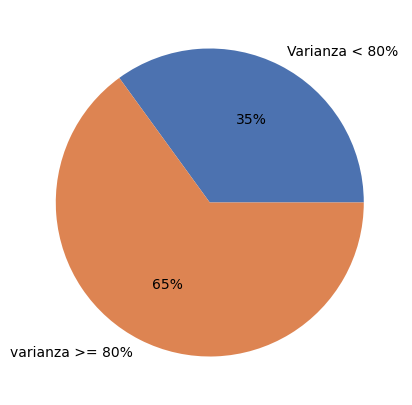

In [106]:
transaccionesVariance=eliminarColumnasVariacion(transaccionesCategorizado,P_thresholdVariance,'isFraud')

Columnas totales 160
Columnas eliminadas 56


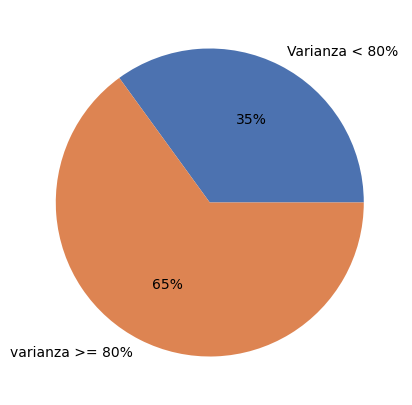

In [107]:
transaccionesVariance=eliminarColumnasVariacion(transaccionesCategorizado,P_thresholdVariance,'isFraud')

Columnas totales 21
Columnas eliminadas 0


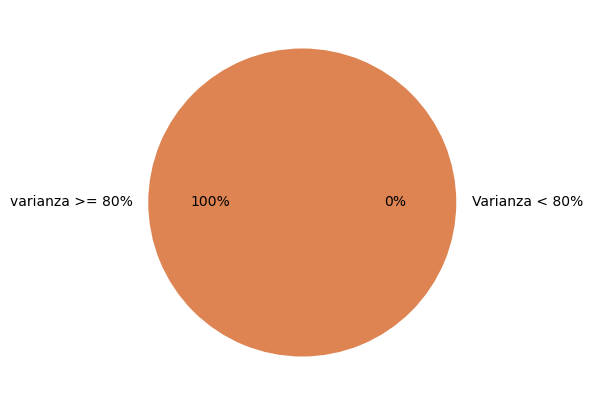

In [108]:
identidadesVariance=eliminarColumnasVariacion(identidadesCategorizado,P_thresholdVariance,'isFraud')

### Mergear los dos datasets

In [109]:
dfCompleto = pd.merge(transaccionesVariance, identidadesVariance, on = 'TransactionID', how = 'left')

### Tratamiento de valores ausentes

In [110]:
#Separar las columnas en categóricas y continuas
columnas=dfCompleto.columns
categoricas=['card4','card6','ProductCD','id_12','id_15','id_16','id_28','id_29','id_31','id_35','id_36','id_37','id_38','DeviceType']
continuas=columnas[np.logical_not(columnas.isin(categoricas))]

In [111]:
#### Sustituir los valores ausentes de las variables categóricas por '0'
def sustituirAusentes(columnas,df,estrategia):
    for c in columnas:
        if estrategia=='median':
            df[c] = df[c].fillna(df[c].median())
            df[c] = df[c].replace(np.inf,df[c].median())
        elif estrategia=='mean':
            df[c] = df[c].fillna(df[c].mean())
            df[c] = df[c].replace(np.inf,df[c].mean())
        else:
            df[c] = df[c].fillna(0)
            df[c] = df[c].replace(np.inf,0)
    return df

In [112]:
#Los valores ausentes de las categóricas se sustituyen por 0
dfCompleto=sustituirAusentes(categoricas,dfCompleto,'0')

#Los valores ausentes de las continuas, se sustituyen por su media
dfCompleto=sustituirAusentes(continuas,dfCompleto,P_estrategiaSustitucionAtributos)

### Separar atributos y target

In [113]:
dfFull=dfCompleto.copy()

In [114]:
indData = dfFull.copy()

In [115]:
indData=indData.drop("isFraud", axis=1) 
indData=indData.drop("TransactionID", axis=1) 

In [116]:
y=dfFull['isFraud'].to_numpy()
X=indData.to_numpy() 

### Análisis de correlaciones

In [117]:
columnasTotales=indData.columns

In [118]:
#Quitar del análisis de correlaciones las variables categóricas
categoricas=['card4','card6','ProductCD','id_12','id_15','id_16','id_28','id_29','id_31','id_35','id_36','id_37','id_38','DeviceType']
columnasContinuas = [elemento for elemento in columnasTotales if elemento not in categoricas]
print(len(columnasContinuas))

108


In [119]:
print(columnasContinuas)

['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'V12', 'V13', 'V19', 'V20', 'V29', 'V30', 'V53', 'V54', 'V56', 'V60', 'V61', 'V62', 'V64', 'V69', 'V70', 'V95', 'V96', 'V97', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V302', 'V303', 'V304', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20']


In [120]:
dfCorrCompleto=indData[columnasContinuas].drop("TransactionDT", axis=1)

In [121]:
import matplotlib.pyplot as plt 
#Se muestran a continuación todas las  correlaciones. 
dfCorr=(dfCorrCompleto).corr()
#Se ponen a 0 los pares de atributos iguales.
np.fill_diagonal(dfCorr.values,0)
dfCorr.style.background_gradient(cmap=plt.get_cmap('Blues'), axis=1)

In [131]:
### Se seleccionan las 20 variables con mayor correlación
correlacionesOrdenadas = dfCorr.abs().unstack().sort_values(ascending=False)
correlacionesOrdenadas2 = correlacionesOrdenadas[correlacionesOrdenadas < 1]


In [132]:
#correlacionesTop
correlacionesOrdenadas3=correlacionesOrdenadas2[correlacionesOrdenadas2 >= P_eliminarUmbralCorrelacion]
correlacionesOrdenadas3

Series([], dtype: float64)

In [133]:
### Obtener el listado a eliminar
columnasAeliminar=[]
listadoCorrelaciones = correlacionesOrdenadas3.keys().tolist()
setCorrelaciones = set([])
for i in range (len(listadoCorrelaciones)):
    l=sorted(list(listadoCorrelaciones[i]))    
    setCorrelaciones.add(l[0]+"#"+l[1])
i=0
for elem in setCorrelaciones:
    primerElemento = elem.split("#")[0]
    #eliminar el primer elemento 
    columnasAeliminar.insert(i,primerElemento)

print(columnasAeliminar)
print(len(columnasAeliminar))

[]
0


In [134]:
columnasSinCorrelacionse=[elemento for elemento in columnasTotales if elemento not in columnasAeliminar]
print(len(columnasSinCorrelacionse))

122


In [129]:
indData=indData[columnasSinCorrelacionse]
indData

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,V12,V13,V19,V20,V29,V30,V53,V54,V56,V60,V61,V62,V64,V69,V70,V95,V96,V97,V99,V100,V101,V102,V103,V104,V105,V106,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V285,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,86400,68.50,590539.0,13926,362.555488,150.0,590490.0,142.0,590539.0,315.0,87.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.0000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,-10.170502,174716.584708,1.615585,-6.69871,99.745325,0.0,48.053071,0.0,0.0,189.451377,353.128174,403.882666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86401,29.00,590539.0,2755,404.000000,150.0,590539.0,102.0,590539.0,325.0,87.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-10.170502,174716.584708,1.615585,-6.69871,99.745325,0.0,48.053071,0.0,0.0,189.451377,353.128174,403.882666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.00,590539.0,4663,490.000000,150.0,590535.0,166.0,590538.0,330.0,87.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-10.170502,174716.584708,1.615585,-6.69871,99.745325,0.0,48.053071,0.0,0.0,189.451377,353.128174,403.882666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499,50.00,590539.0,18132,567.000000,150.0,590539.0,117.0,590538.0,476.0,87.0,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.0000,0.000000,1.0,48.0,28.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,50.000000,1758.000000,925.000000,0.0,354.000000,135.0,50.0,1404.0,790.0,0.000000,0.000000,0.000000,1.0,28.0,0.0,0.0,0.0,10.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,1758.000000,925.000000,0.0,354.000000,0.0,135.0,0.000000,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000,-10.170502,174716.584708,1.615585,-6.69871,99.745325,0.0,48.053071,0.0,0.0,189.451377,353.128174,403.882666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,86506,50.00,590506.0,4497,514.000000,150.0,590539.0,102.0,590539.0,420.0,87.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,123.982137,0.559711,0.599166,0.816371,0.847843,0.38784,0.406436,0.577586,0.619982,1.120979,0.142537,0.829785,0.867563,0.141825,0.3902,0.407924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

In [141]:
### Gráfico de las correlaciones Top
numVariablesAnalizar=10
correlacionesTop = correlacionesOrdenadas2.head(numVariablesAnalizar)
#correlacionesTop

In [142]:
listado1=correlacionesTop.keys().tolist()

listado=[]
for i in range (numVariablesAnalizar):
    l=list(listado1[i])
    listado+=l
listadoFinal=list(set(listado))

In [143]:
listadoFinal

['C7', 'V95', 'C12', 'V293', 'V101', 'V279', 'V103', 'V97']

In [144]:
dfCorrReducido=indData[listadoFinal]
dfCorr2=(dfCorrReducido).corr()
np.fill_diagonal(dfCorr2.values,0)
dfCorr2.style.background_gradient(cmap=plt.get_cmap('Blues'), axis=1)

,C7,V95,C12,V293,V101,V279,V103,V97
C7,0.000000,-0.001243,0.999489,-0.000745,-0.001323,-0.000718,-0.001734,-0.002027
V95,-0.001243,0.000000,-0.001256,0.998474,0.999594,0.998709,0.941031,0.936049
C12,0.999489,-0.001256,0.000000,-0.000801,-0.001339,-0.000772,-0.001750,-0.002028
V293,-0.000745,0.998474,-0.000801,0.000000,0.998918,0.999568,0.936851,0.930759
V101,-0.001323,0.999594,-0.001339,0.998918,0.000000,0.998452,0.937884,0.931851
V279,-0.000718,0.998709,-0.000772,0.999568,0.998452,0.000000,0.939928,0.934758
V103,-0.001734,0.941031,-0.001750,0.936851,0.937884,0.939928,0.000000,0.998789
V97,-0.002027,0.936049,-0.002028,0.930759,0.931851,0.934758,0.998789,0.000000


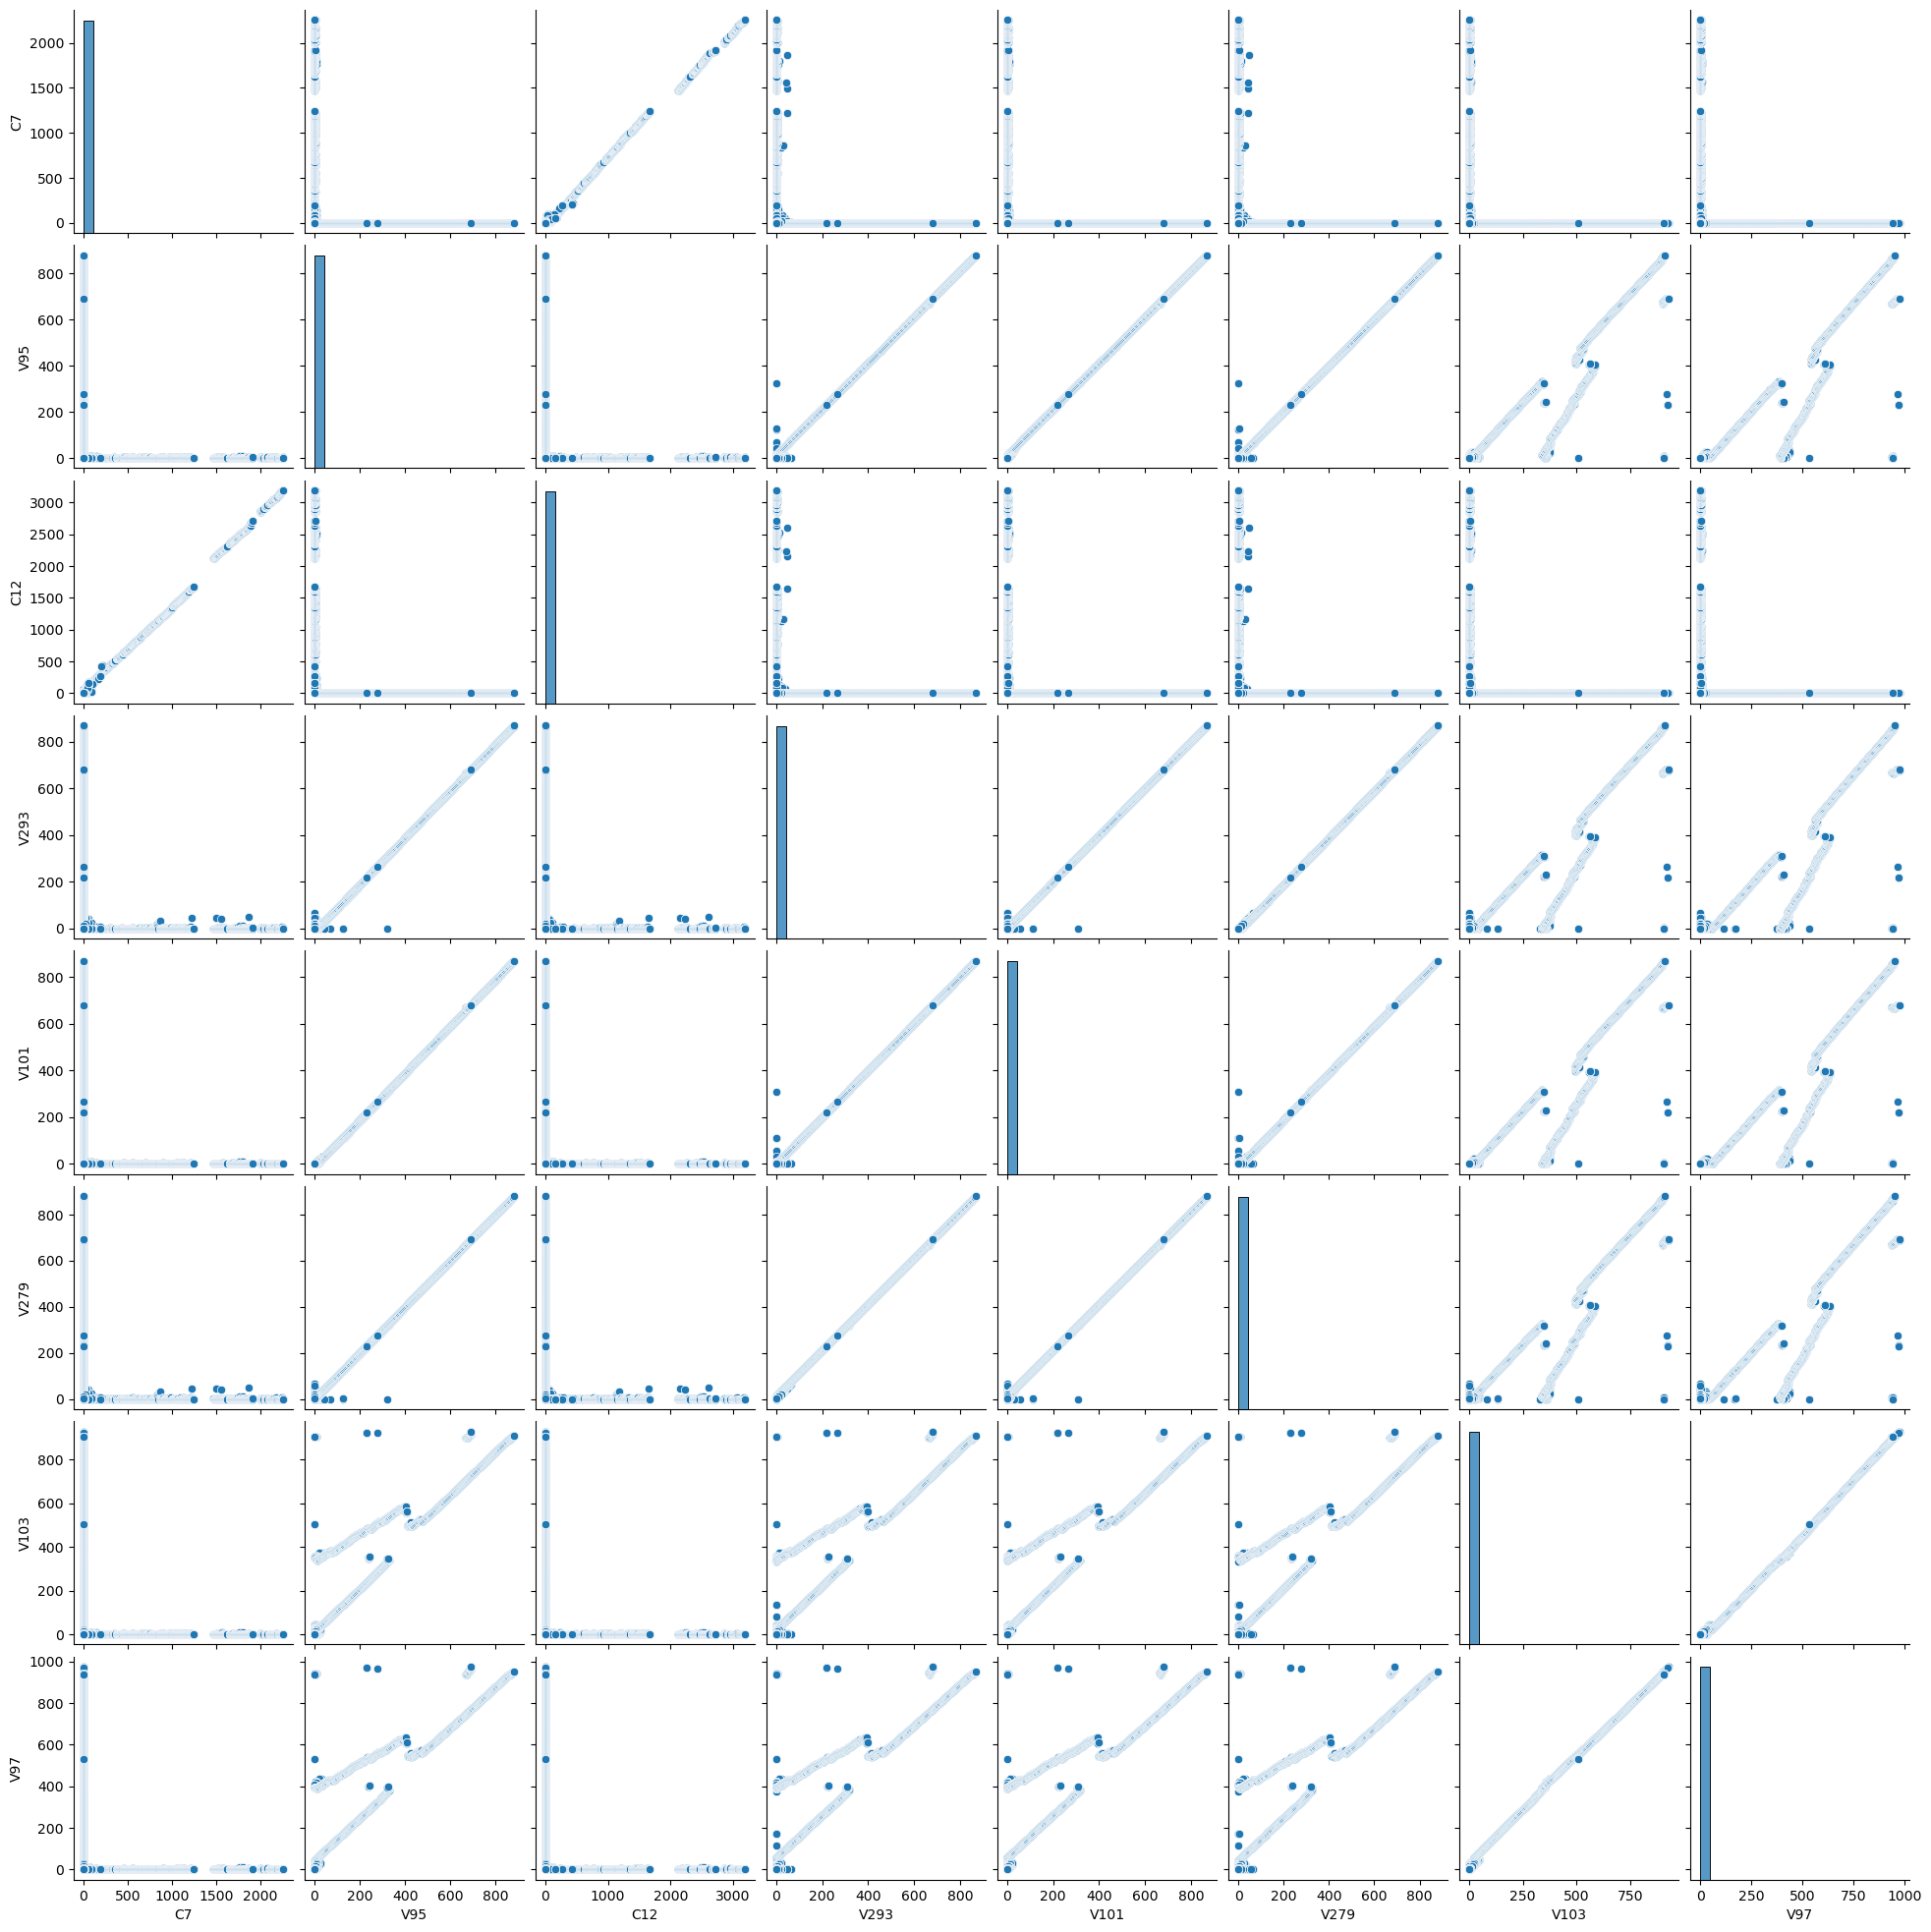

In [148]:
#Se pintan graficamente las 6 variables con más correlación
sns.pairplot(indData,  vars=listadoFinal)
plt.show()

### Selección de atributos por información mútua

In [54]:
y=dfFull['isFraud'].to_numpy()
X=indData.to_numpy() 

In [55]:
#https://www.rasgoml.com/feature-engineering-tutorials/feature-selection-using-mutual-information-in-scikit-learn
#Seleccionar las 'n' mejores columnas
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif,chi2

selector = SelectKBest(mutual_info_classif,k=P_numatributosImportantes)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape

cols = selector.get_support(indices=True)
selected_columns = indData.iloc[:,cols].columns.tolist()
indData[selected_columns].head()

,ProductCD,card3,card4,card5,card6,addr2,V12,V13,V19,V20,V53,V54,V56,V61,V62,V282,V283,V290,V291,V292,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,id_36
0,590539.0,150.0,590490.0,142.0,590539.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0
1,590539.0,150.0,590539.0,102.0,590539.0,87.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0
2,590539.0,150.0,590535.0,166.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0
3,590539.0,150.0,590539.0,117.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0
4,590506.0,150.0,590539.0,102.0,590539.0,87.0,0.559711,0.599166,0.816371,0.847843,0.577586,0.619982,1.120979,0.829785,0.867563,1.0,1.0,1.0,1.0,1.0,0.000000,70787.000000,1.615585,-6.69871,100.000000,48.053071,166.000000,542.000000,144.000000,144232.0


In [56]:
fit=selector.fit(X, y)

#### Atributos con más importancia

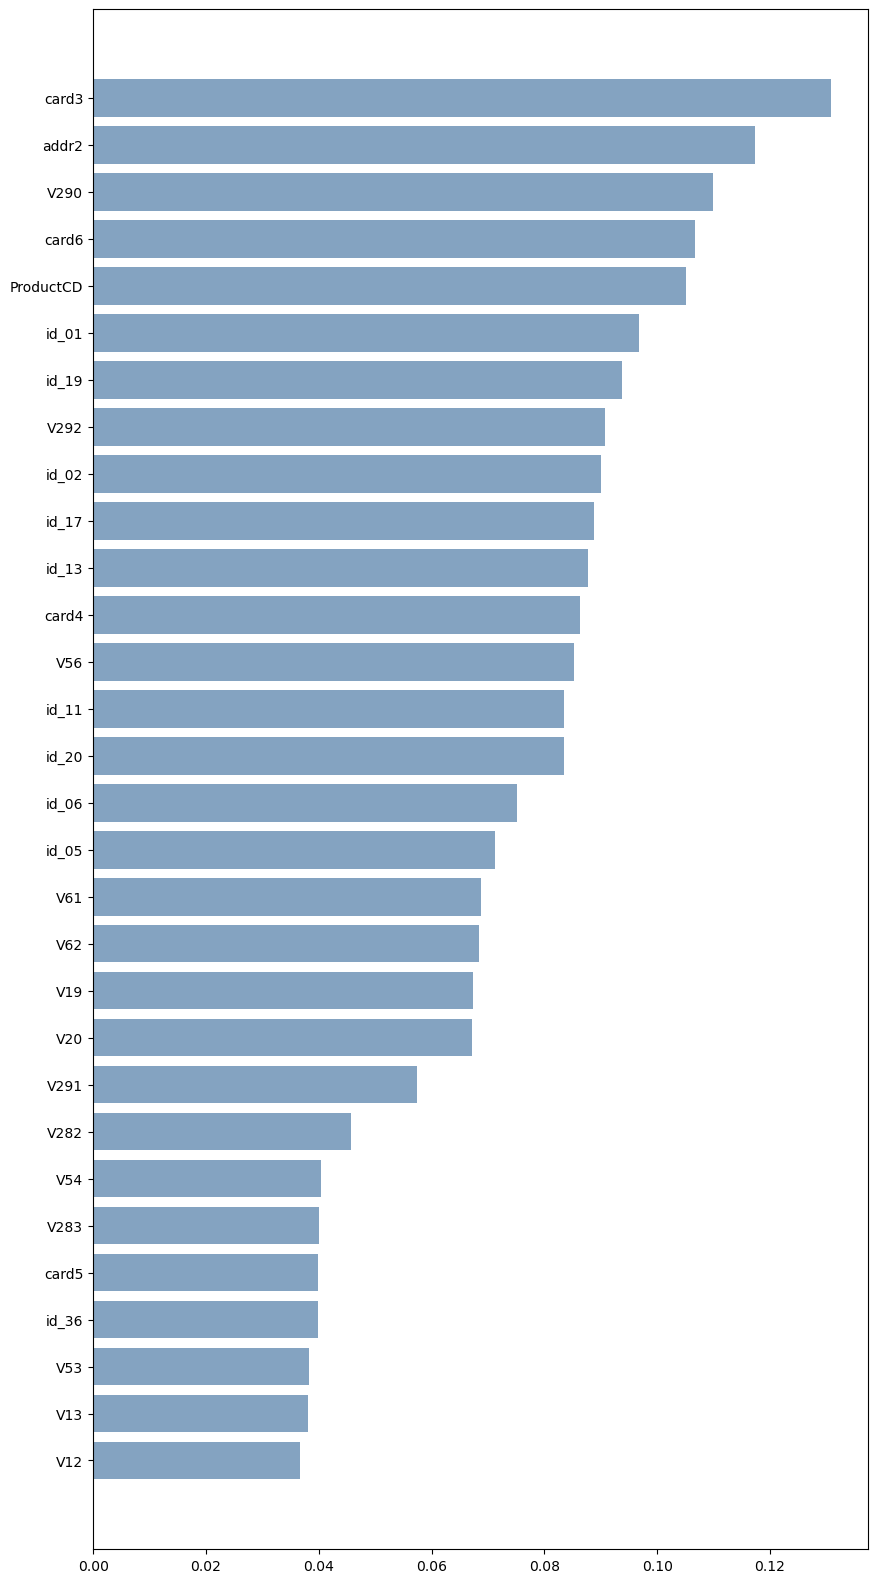

In [57]:
indices = np.argsort(fit.scores_)[::-1]

features = []

for i in range(P_numatributosImportantes):
    features.append(indData.columns[indices[i]])   

importancias=pd.DataFrame()
importancias['features']=features
importancias['scores']=fit.scores_[indices[range(P_numatributosImportantes)]]
importancias.sort_values('scores',inplace=True, ascending=True)
plt.figure(figsize=(10,20))
plt.barh(importancias['features'], importancias['scores'], color=(0.2, 0.4, 0.6, 0.6), align='center')
plt.show()

### Distribución y outliers de los atributos

In [59]:
#Quitar las variables categóricas
def pintarDistribucionesYOutliers(importancias):
    categoricas=['card4','card6','ProductCD','id_12','id_15','id_16','id_28','id_29','id_31','id_35','id_36','id_37','id_38','DeviceType']
    for importancia in importancias:
       
        if importancia not in categoricas and importancia not in columnasAeliminar:
            print(importancia)
            fig, axes = plt.subplots(1, 2, figsize=(10,4))

            sns.distplot(indData[importancia],kde=True,bins=20,ax=axes[0])    

            sns.boxplot(x=importancia,data=indData,ax=axes[1])
            plt.show()
        
       
        

In [60]:
if P_pintarDistribucionYoutliers==True:
    pintarDistribucionesYOutliers(importancias['features'])

##### Guardar pickle

In [61]:
import pickle
selected_columns_cp=selected_columns.copy()

#Necesarias para luego calcular el ClientId
if np.isin(['D1'],selected_columns_cp).any()==False:
    selected_columns_cp.append('D1')    
if  np.isin(['TransactionDT'],selected_columns_cp).any()==False:
    selected_columns_cp.append('TransactionDT')
if  np.isin(['addr1'],selected_columns_cp).any()==False:
    selected_columns_cp.append('addr1')
if  np.isin(['card1'],selected_columns_cp).any()==False:
    selected_columns_cp.append('card1')

selected_columns_cp.append('isFraud')
dataPickle = indData.copy()
dataPickle['isFraud']=dfFull['isFraud']
dataPickle = dataPickle[selected_columns_cp]

filePickle = open('filePickleTmp.pkl','wb')
pickle.dump(dataPickle,filePickle)
filePickle.close()

#### Cargar pickle

In [62]:
import pickle
f = open('filePickleTmp.pkl','rb')
dataPickle = pickle.load(f)
f.close
dataPickle.head()

,ProductCD,card3,card4,card5,card6,addr2,V12,V13,V19,V20,V53,V54,V56,V61,V62,V282,V283,V290,V291,V292,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,id_36,D1,TransactionDT,addr1,card1,isFraud
0,590539.0,150.0,590490.0,142.0,590539.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,14.0,86400,315.0,13926,0
1,590539.0,150.0,590539.0,102.0,590539.0,87.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86401,325.0,2755,0
2,590539.0,150.0,590535.0,166.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86469,330.0,4663,0
3,590539.0,150.0,590539.0,117.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,112.0,86499,476.0,18132,0
4,590506.0,150.0,590539.0,102.0,590539.0,87.0,0.559711,0.599166,0.816371,0.847843,0.577586,0.619982,1.120979,0.829785,0.867563,1.0,1.0,1.0,1.0,1.0,0.000000,70787.000000,1.615585,-6.69871,100.000000,48.053071,166.000000,542.000000,144.000000,144232.0,0.0,86506,420.0,4497,0


### Comprobar relación entre outliers y componentes de Fraude

In [63]:
dfFilas = dataPickle.copy()
identificadores=[]
for i in range(0,len(dataPickle)):
    identificadores.insert(i,i)
dfFilas['id']=identificadores

In [64]:
def calcularRangoIQ(df,columna):
    q1 = np.quantile(df[columna], 0.01)
    q3 = np.quantile(df[columna], 0.99)

    # Calcular el rango intercuartílico
    iqr = q3 - q1

    # Definir el rango para identificar outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identificar outliers
    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]
    
    return outliers

def pintarGrafico(data,labels):
    plt.figure(figsize=(4,4))
    colors = sns.color_palette('deep')
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()
    
def verOutliersPorTarjet(columnas,df):
    
    filasFraudeIds=set([])
    filasNoFraudeIds=set([])
    filasTotalIds=set([])
    
    resumenOutliers = pd.DataFrame()
    columnasOutliers = []
    outliersFraude = []
    outliersNoFraude = []
    outliersTotal = []
    i=0    
    for columna in columnas: 
        
        if columna!='isFraud':
        
            print("------- COLUMNA ------- "+columna)       

            #Outliers en total en esa columna
            outlierDF=calcularRangoIQ(df,columna)     
            print("Outliers: ")
            print(str(len(outlierDF))) 

            #Outliers para fraude en esa columna
            outlierDFFraude=outlierDF[outlierDF['isFraud']==1]
            print("Total filas fraude con outlier "+str(len(outlierDFFraude))+"\r\n")

            #Outliers para no fraude en esa columna
            outlierDFNoFraude=outlierDF[outlierDF['isFraud']==0]
            print("Total filas no fraude con outlier "+str(len(outlierDFNoFraude))+"\r\n")

            ids=(outlierDF['id'])        
            setIds=set(ids)        
            filasTotalIds=filasTotalIds.union(setIds)

            idfs=(outlierDFFraude['id'])        
            setIdfs=set(idfs)        
            filasFraudeIds=filasFraudeIds.union(setIdfs)

            idnfs=(outlierDFNoFraude['id'])        
            setIdnfs=set(idnfs)        
            filasNoFraudeIds=filasNoFraudeIds.union(setIdnfs)
            
            if len(outlierDF)>0:
                columnasOutliers.insert(i,columna)
                outliersFraude.insert(i,len(outlierDFFraude))
                outliersNoFraude.insert(i,len(outlierDFNoFraude))
                outliersTotal.insert(i,len(outlierDF))                
                i+=1
        
        
    print("------- Total filas --------"+str(len(df)))    
    print("------- Total filas con outliers --------"+str(len(filasTotalIds))+"\r\n")
    
    print("------- Total filas con fraude --------"+str(len(df[df['isFraud']==1])))    
    print("------- Total filas con outliers fraude --------"+str(len(filasFraudeIds))+"\r\n")
    
    print("------- Total filas no fraude --------"+str(len(df[df['isFraud']==0]))) 
    print("------- Total filas con outliers no fraude --------"+str(len(filasNoFraudeIds)))
    
    ## Pintar gráficos    
    
    pintarGrafico([len(df),len(filasTotalIds)],['Total','Outliers Total'])
    pintarGrafico([len(df[df['isFraud']==1]),len(filasFraudeIds)],['Total fraude','Outliers fraude'])
    pintarGrafico([len(df[df['isFraud']==0]),len(filasNoFraudeIds)],['Total No fraude','Outliers NO fraude'])
    
    ## Crear df de resumen de outliers
    resumenOutliers['Atributo']=columnasOutliers
    resumenOutliers['Outliers fraude']=outliersFraude
    resumenOutliers['Outliers no fraude']=outliersNoFraude
    resumenOutliers['Outliers total']=outliersTotal
    
      
    return filasTotalIds, resumenOutliers #Ids de Filas con outliers, tabla resumen de outliers


------- COLUMNA ------- ProductCD
Outliers: 
0
Total filas fraude con outlier 0

Total filas no fraude con outlier 0

------- COLUMNA ------- card3
Outliers: 
0
Total filas fraude con outlier 0

Total filas no fraude con outlier 0

------- COLUMNA ------- card4
Outliers: 
1577
Total filas fraude con outlier 41

Total filas no fraude con outlier 1536

------- COLUMNA ------- card5
Outliers: 
0
Total filas fraude con outlier 0

Total filas no fraude con outlier 0

------- COLUMNA ------- card6
Outliers: 
1616
Total filas fraude con outlier 39

Total filas no fraude con outlier 1577

------- COLUMNA ------- addr2
Outliers: 
4353
Total filas fraude con outlier 445

Total filas no fraude con outlier 3908

------- COLUMNA ------- V12
Outliers: 
120
Total filas fraude con outlier 18

Total filas no fraude con outlier 102

------- COLUMNA ------- V13
Outliers: 
3
Total filas fraude con outlier 0

Total filas no fraude con outlier 3

------- COLUMNA ------- V19
Outliers: 
11
Total filas fraude 

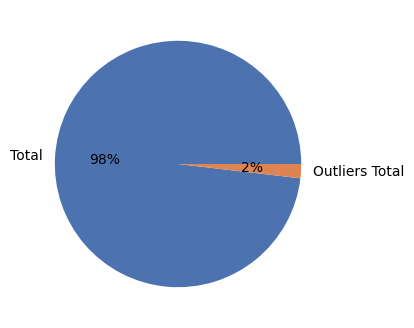

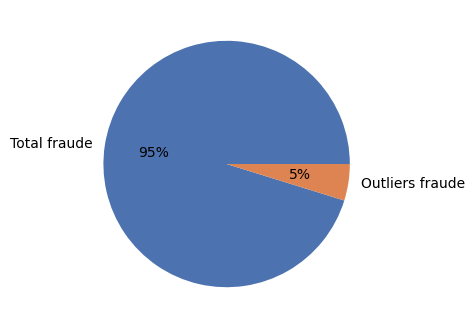

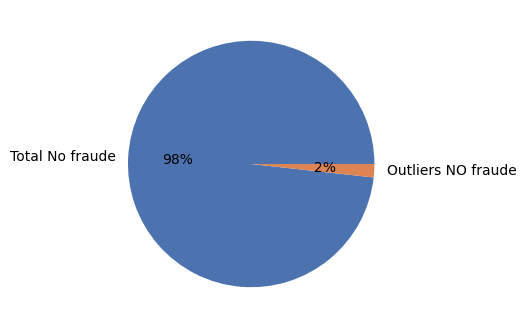

In [65]:
filasIds,dfResumenOutliers=verOutliersPorTarjet(dfFilas.columns,dfFilas)

In [66]:
dfResumenOutliers.sort_values('Outliers total',ascending=False)

,Atributo,Outliers fraude,Outliers no fraude,Outliers total
2,addr2,445,3908,4353
18,id_06,225,2286,2511
1,card6,39,1577,1616
0,card4,41,1536,1577
9,V56,73,807,880
14,V290,72,691,763
15,V291,146,548,694
16,V292,106,578,684
13,V283,169,416,585
19,id_11,12,381,393


In [67]:
### Eliminar filas con outliers
dfFilasSinOutliers = dfFilas.copy()
dfFilasSinOutliers = dfFilasSinOutliers[np.logical_not(dfFilas['id'].isin(filasIds))] ## Estos son los registros sin outliers
dfFilasSinOutliers = dfFilasSinOutliers.drop("id", axis=1)

In [68]:
dfFilasSinOutliers

,ProductCD,card3,card4,card5,card6,addr2,V12,V13,V19,V20,V53,V54,V56,V61,V62,V282,V283,V290,V291,V292,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,id_36,D1,TransactionDT,addr1,card1,isFraud
0,590539.0,150.0,590490.0,142.0,590539.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,14.0,86400,315.0,13926,0
1,590539.0,150.0,590539.0,102.0,590539.0,87.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86401,325.0,2755,0
2,590539.0,150.0,590535.0,166.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86469,330.0,4663,0
3,590539.0,150.0,590539.0,117.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,112.0,86499,476.0,18132,0
4,590506.0,150.0,590539.0,102.0,590539.0,87.0,0.559711,0.599166,0.816371,0.847843,0.577586,0.619982,1.120979,0.829785,0.867563,1.0,1.0,1.0,1.0,1.0,0.000000,70787.000000,1.615585,-6.69871,100.000000,48.053071,166.000000,542.000000,144.000000,144232.0,0.0,86506,420.0,4497,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,590539.0,150.0,590535.0,226.0,590538.0,87.0,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,29.0,15811047,272.0,6550,0
590536,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,15811049,204.0,10444,0
590537,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,15811079,231.0,12037,0
590538,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.0,7.0,1.0,2.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,22.0,15811088,387.0,7826,0


In [69]:
if P_eliminarOutliers == True:
    dataPickle = dfFilasSinOutliers

In [70]:
dataPickle

,ProductCD,card3,card4,card5,card6,addr2,V12,V13,V19,V20,V53,V54,V56,V61,V62,V282,V283,V290,V291,V292,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,id_36,D1,TransactionDT,addr1,card1,isFraud
0,590539.0,150.0,590490.0,142.0,590539.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,14.0,86400,315.0,13926,0
1,590539.0,150.0,590539.0,102.0,590539.0,87.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86401,325.0,2755,0
2,590539.0,150.0,590535.0,166.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86469,330.0,4663,0
3,590539.0,150.0,590539.0,117.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,112.0,86499,476.0,18132,0
4,590506.0,150.0,590539.0,102.0,590539.0,87.0,0.559711,0.599166,0.816371,0.847843,0.577586,0.619982,1.120979,0.829785,0.867563,1.0,1.0,1.0,1.0,1.0,0.000000,70787.000000,1.615585,-6.69871,100.000000,48.053071,166.000000,542.000000,144.000000,144232.0,0.0,86506,420.0,4497,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,590539.0,150.0,590535.0,226.0,590538.0,87.0,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,29.0,15811047,272.0,6550,0
590536,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,15811049,204.0,10444,0
590537,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,15811079,231.0,12037,0
590538,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.0,7.0,1.0,2.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,22.0,15811088,387.0,7826,0


### Almacentamiento DataFrame en Pickles

In [71]:
import pickle

filePickle = open('filePickle.pkl','wb')
pickle.dump(dataPickle,filePickle)
filePickle.close()

In [72]:
dataPickle

,ProductCD,card3,card4,card5,card6,addr2,V12,V13,V19,V20,V53,V54,V56,V61,V62,V282,V283,V290,V291,V292,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,id_36,D1,TransactionDT,addr1,card1,isFraud
0,590539.0,150.0,590490.0,142.0,590539.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,14.0,86400,315.0,13926,0
1,590539.0,150.0,590539.0,102.0,590539.0,87.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86401,325.0,2755,0
2,590539.0,150.0,590535.0,166.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,86469,330.0,4663,0
3,590539.0,150.0,590539.0,117.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,112.0,86499,476.0,18132,0
4,590506.0,150.0,590539.0,102.0,590539.0,87.0,0.559711,0.599166,0.816371,0.847843,0.577586,0.619982,1.120979,0.829785,0.867563,1.0,1.0,1.0,1.0,1.0,0.000000,70787.000000,1.615585,-6.69871,100.000000,48.053071,166.000000,542.000000,144.000000,144232.0,0.0,86506,420.0,4497,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,590539.0,150.0,590535.0,226.0,590538.0,87.0,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,29.0,15811047,272.0,6550,0
590536,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,15811049,204.0,10444,0
590537,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,0.0,15811079,231.0,12037,0
590538,590539.0,150.0,590539.0,224.0,590538.0,87.0,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.0,7.0,1.0,2.0,1.0,-10.170502,174716.584708,1.615585,-6.69871,99.745325,48.053071,189.451377,353.128174,403.882666,0.0,22.0,15811088,387.0,7826,0


### Validación de resultados

In [73]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
def validarParametros(df):    
    
    metricasClas = {
      'AUC':   metrics.roc_auc_score,  
      'ACC':    metrics.accuracy_score,
    }
    
    dataX=df.drop('isFraud',axis=1)
    tarjetY=df[['isFraud']]

    X_train, X_test, y_train, y_test \
    = train_test_split(dataX, tarjetY, stratify=tarjetY, test_size=0.2, random_state=0)
    parametrosDT={'criterion': 'gini', 'max_depth': 20,'random_state':42}
    model=DecisionTreeClassifier(**parametrosDT)
    
    model.fit(X_train,y_train)
    y_pred =  model.predict(X_test)
   
        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate) 
    
    ACC = metricasClas['ACC'](y_test, y_pred)
   
    print("%s\n AUC: %.3f ACC: %.3f " % ('MÉTRICAS -->',roc_auc, ACC))  
   

In [74]:
validarParametros(dataPickle)

MÉTRICAS -->
 AUC: 0.685 ACC: 0.969 
